In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GPyOpt
import GPy
from numba import jit

import time

from bo import bayesianOptimization
from acquisitions import ei, rollout_utility_archive, rollout_mcmc, policy
from utils import minimize, gap, generate_init, fit

In [5]:
norm = True
objective_true  = GPyOpt.objective_examples.experiments2d.branin(normalized = norm)               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.branin(sd = 0.0001,normalized = norm)         # noisy version
bounds = objective_true.bounds     

In [3]:
objective_true  = GPyOpt.objective_examples.experiments2d.l1()               # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.l1()         # noisy version
bounds = objective_true.bounds     

In [6]:
bounds

[(0, 1), (0, 1)]

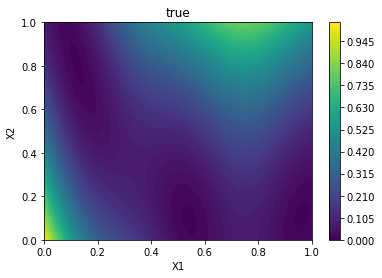

In [7]:
grid = 100
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))
_Y = objective_true.f(_X)

plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("true")
plt.show()

In [10]:
fmin = objective_true.f(minimize(objective_true.f,bounds,grid=500))[0][0]

In [11]:
fmin

1.0000000403549891

In [16]:
fmin = objective_true.f(minimize(objective_true.f,bounds,grid=500))[0][0]

TypeError: unsupported operand type(s) for *: 'int' and 'method'

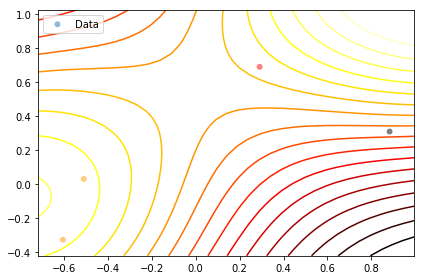

In [7]:
%%prun
X = generate_init(bounds,5) 
Y = objective_true.f(X)

kernel = GPy.kern.RBF(2, ARD=False)
model = fit(X,Y,kernel)

model.plot()

In [8]:
%%prun
kernel = GPy.kern.RBF(2, ARD=False)
model = fit(X,Y,kernel)

In [11]:
%%prun
h=4
N_q=1
n_sample = 5
x = np.array([[0.75,0.5]])
y = rollout_mcmc(x = x,
                        bounds = bounds,
                        func_policy=policy, 
                        depth_h = h, 
                        _queries = X, 
                        _values = Y,
                        n_sample = n_sample,
                        decay_rate = .9,
                        length_scale = 0.2)

In [30]:
%%prun
array = np.array([[1,2,3,4,5,6,7,8,9,10]])
hoge = np.copy(array)

In [18]:
%%prun
h=4
N_q=1
n_sample = 5
x = np.array([[0.75,0.5]])
y = ei(x,bounds,model)

In [22]:
grid = 10
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))

h=4
N_q=1
n_sample = 5
_Y = np.array([])
for i in range(_X.shape[0]):
    print(i)
    x = _X[i:i+1]
    y = rollout_mcmc(x = x,
                        bounds = bounds,
                        func_policy=policy, 
                        depth_h = h, 
                        _queries = X, 
                        _values = Y,
                        n_sample = n_sample,
                        decay_rate = .9,
                        length_scale = 0.2)
    _Y = np.concatenate([_Y,y[0]])
_Y = _Y.T

0
1
2


KeyboardInterrupt: 

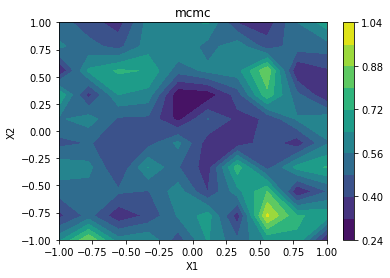

In [9]:
plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("mcmc")
plt.show()

## bench marks

In [8]:
obj_f = objective_true.f
kernel = GPy.kern.RBF(2, ARD=True)
seed = 2
np.random.seed(seed=seed)

h=2
N_q=5
N = 7
n_sample = 5
init_n=0
initpoints = [np.array([[0.8, 0.8]]), np.array([[-0.98, 0]]), np.array([[0, -0.98]]), np.array([[0.8, -0.5]])]

n = 4
queriesei = {}
valuesei={}
gapsei=[]
queriesro = {}
valuesro={}
gapsro=[]

for i in range(n):
    print("n_ei",i)
    initpoint = initpoints[i]
    _query, _value = bayesianOptimization(obj_f,
                                          ei,
                                          bounds,
                                          depth_h = h,
                                          N = N,
                                          initial_n=init_n,
                                          initpoint = initpoint,
                                          N_q = N_q,
                                          n_sample = n_sample,
                                          ARD_Flag = False,
                                          length_scale = 0.2
                                          )
    queriesei[i] = _query
    valuesei[i] = _value
    gapsei.append(gap(_value, fmin=fmin))

for i in range(n):
    print("n_rollout", i)
    initpoint = initpoints[i]
    _query, _value = bayesianOptimization(obj_f,
                                          rollout_mcmc,
                                          bounds,
                                          depth_h = h,
                                          N = N,
                                          initial_n=init_n,
                                          initpoint = initpoint,
                                          N_q = N_q,
                                          n_sample = n_sample,
                                          decay_rate=.9,
                                          ARD_Flag = False,
                                          length_scale = 0.2
                                          )
    queriesro[i] = _query
    valuesro[i] = _value
    gapsro.append(gap(_value, fmin=fmin))


n_ei 0
0
1
2
3
4
5
n_ei 1
0
1
2
3
4
5
n_ei 2
0
1
2
3
4
5
n_ei 3
0
1
2
3
4
5
n_rollout 0
0
1
2
3
4
5
n_rollout 1
0
1
2
3
4
5
n_rollout 2
0
1
2
3
4
5
n_rollout 3
0
1
2
3
4
5


In [9]:
queriesei

{0: array([[ 0.8       ,  0.8       ],
        [-1.        , -1.        ],
        [-1.        ,  0.77777778],
        [ 0.77777778, -1.        ],
        [-0.11111111, -0.11111111],
        [ 1.        , -0.11111111],
        [-0.11111111,  1.        ]]), 1: array([[-0.98      ,  0.        ],
        [ 0.55555556, -1.        ],
        [ 0.55555556,  0.77777778],
        [-0.55555556,  1.        ],
        [-0.55555556, -1.        ],
        [ 1.        , -0.11111111],
        [ 0.11111111, -0.11111111]]), 2: array([[ 0.        , -0.98      ],
        [-1.        ,  0.55555556],
        [ 0.77777778,  0.77777778],
        [ 1.        , -0.33333333],
        [-1.        , -0.55555556],
        [-0.11111111,  0.11111111],
        [-0.11111111,  1.        ]]), 3: array([[ 0.8       , -0.5       ],
        [-1.        , -1.        ],
        [-1.        ,  0.77777778],
        [ 1.        ,  1.        ],
        [ 0.11111111,  0.33333333],
        [-0.11111111, -0.55555556],
        [-1. 

In [10]:
queriesro

{0: array([[ 0.8       ,  0.8       ],
        [-1.        ,  0.11111111],
        [-0.55555556, -1.        ],
        [ 0.11111111,  0.55555556],
        [ 0.33333333, -1.        ],
        [-0.55555556, -0.11111111],
        [ 0.11111111, -0.33333333]]), 1: array([[-0.98      ,  0.        ],
        [ 0.77777778,  1.        ],
        [ 0.33333333,  0.55555556],
        [-0.55555556,  0.11111111],
        [-0.11111111,  0.11111111],
        [ 0.11111111,  1.        ],
        [ 0.77777778, -0.55555556]]), 2: array([[ 0.        , -0.98      ],
        [-0.33333333, -1.        ],
        [ 0.77777778,  0.55555556],
        [-0.11111111,  0.33333333],
        [-0.55555556,  0.11111111],
        [ 0.55555556, -0.77777778],
        [-0.33333333,  0.77777778]]), 3: array([[ 0.8       , -0.5       ],
        [-0.77777778,  1.        ],
        [ 1.        ,  0.33333333],
        [ 0.33333333,  1.        ],
        [-0.11111111, -0.77777778],
        [ 0.55555556,  0.77777778],
        [ 0.5

In [11]:
import pickle
with open('rollout_mcmc_h2n5r5l1_opt1.pickle', mode='wb') as f:
     pickle.dump(queriesro, f)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
gapsro

[0.5994919850341538, 0.6239834970092312, 0.5062386913913381, 0.0]

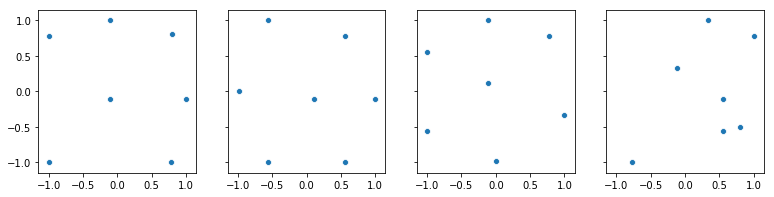

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharex=True,sharey=True,figsize=(13,3))

sns.scatterplot(queriesei[0][:,0],queriesei[0][:,1], ax =ax1)
sns.scatterplot(queriesei[1][:,0],queriesei[1][:,1], ax =ax2)
sns.scatterplot(queriesei[2][:,0],queriesei[2][:,1], ax =ax3)
sns.scatterplot(queriesro[3][:,0],queriesei[3][:,1], ax =ax4)

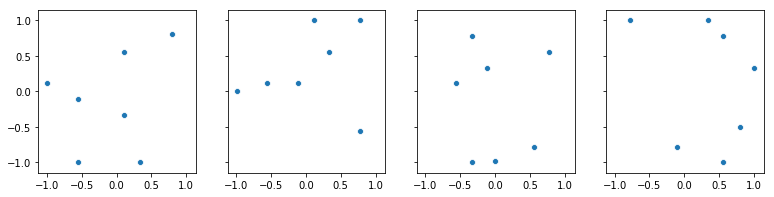

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharex=True,sharey=True,figsize=(13,3))

sns.scatterplot(queriesro[0][:,0],queriesro[0][:,1], ax =ax1)
sns.scatterplot(queriesro[1][:,0],queriesro[1][:,1], ax =ax2)
sns.scatterplot(queriesro[2][:,0],queriesro[2][:,1], ax =ax3)
sns.scatterplot(queriesro[3][:,0],queriesro[3][:,1], ax =ax4)

In [16]:
print("meanEI", np.mean(gapsei))
print("meanRO", np.mean(gapsro))

meanEI 0.4427663867438697
meanRO 0.43242854335868075


In [17]:
print(gapsei)
print(gapsro)

[0.548106957745512, 0.7167198978386287, 0.506238691391338, 0.0]
[0.5994919850341538, 0.6239834970092312, 0.5062386913913381, 0.0]
